# Классификация токсичных комментариев с использованием BERT

## Импорты

In [71]:
%matplotlib inline

# стандартные библиотеки
import numpy as np
import pandas as pd

# библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# модели машинного обучения
from sklearn.linear_model import LinearRegression

# токенизация
from transformers import BertTokenizer
# воспроизводимость
import torch
np.random.seed(42)
torch.manual_seed(42)


from collections import Counter
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import re


# константы
RANDOM_STATE = 42
TEST_SIZE = 0.2

## Загрузка и осмотр данных

In [47]:
try:
    df = pd.read_csv('/datasets/toxic_comments.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')


Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


None

Первые 5 строк датасета:


,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


Статистики датасета:


,Unnamed: 0,toxic
count,159292.000000,159292.000000
mean,79725.697242,0.101612
std,46028.837471,0.302139
min,0.000000,0.000000
25%,39872.750000,0.000000
50%,79721.500000,0.000000
75%,119573.250000,0.000000
max,159450.000000,1.000000



Пропуски в данных:
Unnamed: 0    0
text          0
toxic         0
dtype: int64

Количество дубликатов:
0


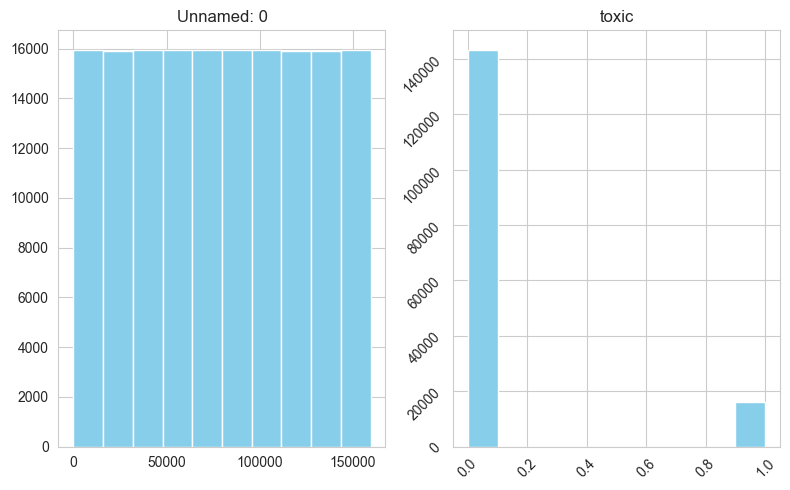

In [48]:
def check_df(df):
    print("\nИнформация о датасете:")
    display(df.info())
    print("Первые 5 строк датасета:")
    display(df.head())
    print("Статистики датасета:")
    display(df.describe())
    print("\nПропуски в данных:")
    print(df.isnull().sum())
    print("\nКоличество дубликатов:")
    print(df.duplicated().sum())

    df.hist(figsize=(8,5), color='skyblue')
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(rotation=45, fontsize=10)
    plt.tight_layout()
    plt.show()

    print()

check_df(df)

In [49]:
# анализ длины текстов
df['text_length'] = df['text'].apply(len)
print("\nСтатистика длины текстов:")
print(df['text_length'].describe())


Статистика длины текстов:
count    159292.000000
mean        393.691303
std         590.111825
min           5.000000
25%          95.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: text_length, dtype: float64


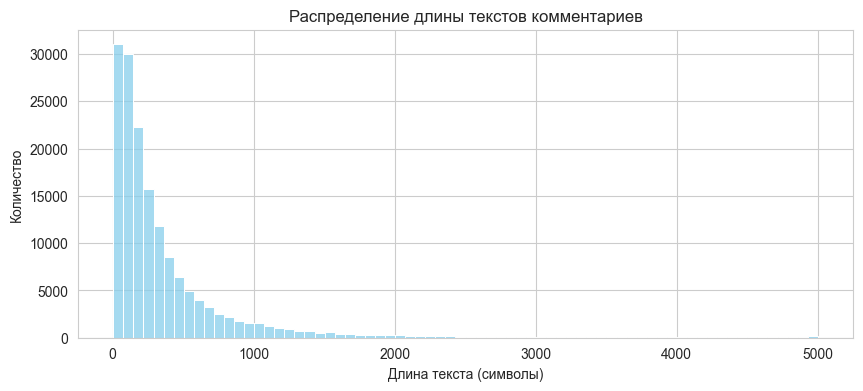

In [50]:
# визуализация распределения длины текстов
plt.figure(figsize=(10, 4))
sns.histplot(df['text_length'], bins=70, color='skyblue')
plt.title('Распределение длины текстов комментариев')
plt.xlabel('Длина текста (символы)')
plt.ylabel('Количество')
plt.show()

**Выводы по загрузке и анализу данных**
- Датасет содержит 159292 строки, столбцы: `text`, `toxic`.
- Столбец `Unnamed: 0` удалю как избыточный.
- Пропуски и дубликаты отсутствуют.
- Распределение классов: ~90% нетоксичных, ~10% токсичных (дисбаланс).
- Для просмотра длины текста был создан столбец `text_length`.
- Длина текстов: средняя ~393 символа, медиана ~205, максимум 5000 (явно выброс, нужно проверить) (BERT принимает до 512 токенов, нужно будет что-то делать с длинными текстами).
- **Следующий шаг**: Исследовательский анализ данных

## EDA + предобработка

Для начала удалю избыточный столбец

In [51]:
df = df.drop(columns=['Unnamed: 0'])
df.shape, df.columns

((159292, 3), Index(['text', 'toxic', 'text_length'], dtype='object'))

In [52]:
# повторно проверим распределение классов
df['toxic'].value_counts(normalize=True)

toxic
0    0.898388
1    0.101612
Name: proportion, dtype: float64

### Анализ длины текстов

In [53]:
df['text_length'].describe()

count    159292.000000
mean        393.691303
std         590.111825
min           5.000000
25%          95.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: text_length, dtype: float64

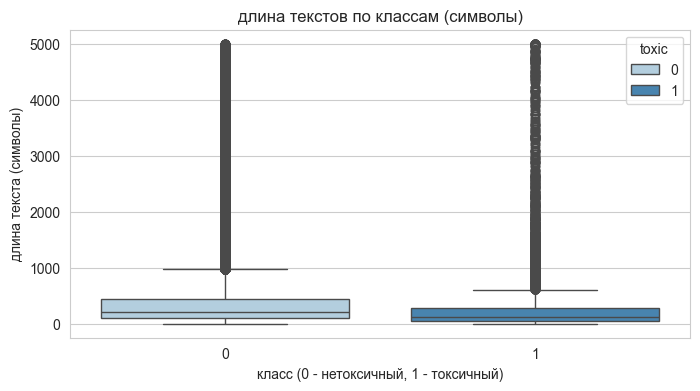

In [54]:
# boxplot длины по классам
plt.figure(figsize=(8, 4))
sns.boxplot(x='toxic', y=df['text'].str.len(), hue='toxic', data=df, palette='Blues')
plt.title('длина текстов по классам (символы)')
plt.xlabel('класс (0 - нетоксичный, 1 - токсичный)')
plt.ylabel('длина текста (символы)')
plt.show()

в данных достаточно много длинных комментариев

так как берт принимает на вход до 512 токенов, а одно слово обычно 1-3 токена, нужно что-то делать с длинными комментариями

In [55]:
df.query('text_length > 500').count()

text           33851
toxic          33851
text_length    33851
dtype: int64

In [59]:
# топ-30 слов по классам
def get_top_words(texts, n=30):
    words = ' '.join(texts).split()
    return Counter(words).most_common(n)

toxic_texts = df[df['toxic'] == 1]['text']
non_toxic_texts = df[df['toxic'] == 0]['text']
print("\nтоп-30 слов в токсичных комментариях:")
print(get_top_words(toxic_texts))
print("\nтоп-30 слов в нетоксичных комментариях:")
print(get_top_words(non_toxic_texts))


топ-30 слов в токсичных комментариях:
[('you', 20267), ('the', 18962), ('a', 18920), ('I', 17737), ('to', 15881), ('and', 14758), ('is', 11268), ('of', 11163), ('your', 7704), ('YOU', 7428), ('that', 7393), ('are', 6323), ('in', 6037), ('You', 5150), ('it', 4929), ('on', 4821), ('for', 4697), ('my', 4550), ('have', 4478), ('not', 4364), ('fuck', 4316), ('with', 3843), ('this', 3837), ('be', 3688), ('"', 3576), ('me', 3568), ('like', 3356), ('i', 3352), ('as', 3031), ('A', 2952)]

топ-30 слов в нетоксичных комментариях:
[('the', 426059), ('to', 272190), ('of', 207649), ('and', 191997), ('a', 182334), ('I', 165741), ('is', 152930), ('you', 136602), ('that', 132779), ('in', 123904), ('for', 91061), ('it', 87520), ('not', 79370), ('on', 79353), ('"', 78009), ('be', 77063), ('this', 67400), ('as', 65122), ('have', 64744), ('are', 59759), ('with', 52457), ('was', 50185), ('your', 47953), ('or', 45622), ('but', 40288), ('an', 38935), ('The', 37967), ('from', 37053), ('article', 36730), ('by'

В данных очень много бесполезных слов, например, артиклей, местоимений. Также слова сами по себе не очень информативны, посмотрим n-граммы и долю капса (это признак токсичности обычно).

In [68]:
# n-граммы
def get_top_ngrams(texts, n=30, ngram_range=(3,3)):
    vec = CountVectorizer(ngram_range=ngram_range, lowercase=True, stop_words='english')
    bag = vec.fit_transform(texts)
    sums = bag.sum(axis=0)
    freqs = [(word, sums[0, idx]) for word, idx in vec.vocabulary_.items()]
    return sorted(freqs, key=lambda x: x[1], reverse=True)[:n]

print("\nТоп-30 биграмм в токсичных комментариях:")
print(get_top_ngrams(toxic_texts, n=30, ngram_range=(2,2)))

print("\nТоп-30 триграмм в токсичных комментариях:")
print(get_top_ngrams(toxic_texts, n=30, ngram_range=(3,3)))


Топ-30 биграмм в токсичных комментариях:
[('fuck fuck', np.int64(2959)), ('nigger nigger', np.int64(2149)), ('hate hate', np.int64(1570)), ('moron hi', np.int64(1474)), ('hi moron', np.int64(1472)), ('pig pig', np.int64(1250)), ('jew fat', np.int64(1234)), ('fat jew', np.int64(1226)), ('shit shit', np.int64(1149)), ('suck suck', np.int64(1136)), ('ass ass', np.int64(1127)), ('bark bark', np.int64(999)), ('wanker wanker', np.int64(963)), ('bullshit bullshit', np.int64(833)), ('balls balls', np.int64(833)), ('nipple nipple', np.int64(763)), ('faggot faggot', np.int64(755)), ('talk page', np.int64(737)), ('die die', np.int64(643)), ('dickhead dickhead', np.int64(625)), ('die fag', np.int64(625)), ('fag die', np.int64(624)), ('faggots faggots', np.int64(624)), ('fucksex fucksex', np.int64(623)), ('fuck yourselfgo', np.int64(621)), ('yourselfgo fuck', np.int64(621)), ('aids aids', np.int64(592)), ('freedom freedom', np.int64(572)), ('super gay', np.int64(501)), ('gay super', np.int64(499))

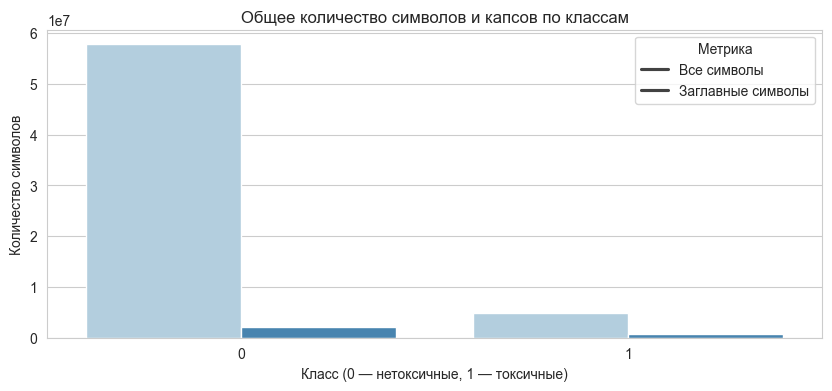

,toxic,metric,count
0,0,total_chars,57808611
1,1,total_chars,4903264
2,0,caps_chars,2035255
3,1,caps_chars,696383


In [69]:
# считаем количество символов и капсов по классам
df['total_chars'] = df['text'].str.len()
df['caps_chars'] = df['text'].apply(lambda x: sum(1 for c in x if c.isupper()))

agg = df.groupby('toxic')[['total_chars', 'caps_chars']].sum().reset_index()

# визуализация
agg_melted = agg.melt(id_vars='toxic', value_vars=['total_chars', 'caps_chars'],
                      var_name='metric', value_name='count')

plt.figure(figsize=(10,4))
sns.barplot(x='toxic', y='count', hue='metric', data=agg_melted, palette='Blues')
plt.title('Общее количество символов и капсов по классам')
plt.xlabel('Класс (0 — нетоксичные, 1 — токсичные)')
plt.ylabel('Количество символов')
plt.legend(title='Метрика', labels=['Все символы', 'Заглавные символы'])
plt.show()
agg_melted

- В биграммах и триграммах очень много слов повторяются, но это не баг, а фича. Люди пишут повторы чтобы усилить эффект. Это сильный индикатор токсичности.
- Отношение капслоковых слов к общему количеству не очень большое, можно все слова привести в нижний регистр.

- загрузим стопслова
- удалим пунктуацию
- удалим все не-ascii символы

In [72]:
# загружаем stopwords
stop_words = set(stopwords.words('english'))

# проверяем не-ascii перед удалением
non_ascii = df[df['text'].str.contains('[^\x00-\x7F]', regex=True, na=False)]
print(f"тексты с не-ascii символами: {len(non_ascii)} ({len(non_ascii)/len(df)*100:.2f}%)")

# функция очистки текста
def clean_text(text):
    # lowercase
    text = text.lower()
    # удаляем не-ascii
    text = re.sub(r'[^\x00-\x7F]', '', text)
    # удаляем пунктуацию
    text = re.sub(r'[^\w\s]', '', text)
    # удаляем stopwords
    words = [word for word in text.split() if word not in stop_words]
    return ' '.join(words)

# применяем очистку
df['clean_text'] = df['text'].apply(clean_text)

тексты с не-ascii символами: 17178 (10.78%)


In [74]:
toxic_texts = df[df['toxic'] == 1]['clean_text']
non_toxic_texts = df[df['toxic'] == 0]['clean_text']
print("\nтоп-30 слов в токсичных комментариях:")
print(get_top_words(toxic_texts))
print("\nтоп-30 слов в нетоксичных комментариях:")
print(get_top_words(non_toxic_texts))


топ-30 слов в токсичных комментариях:
[('fuck', 8662), ('dont', 3877), ('like', 3759), ('shit', 3647), ('wikipedia', 3473), ('nigger', 3295), ('fucking', 3222), ('suck', 3044), ('go', 2924), ('ass', 2652), ('u', 2647), ('hate', 2636), ('get', 2418), ('know', 2341), ('page', 2328), ('gay', 2245), ('im', 2223), ('die', 2136), ('fat', 1978), ('people', 1974), ('faggot', 1962), ('youre', 1925), ('moron', 1885), ('hi', 1709), ('one', 1644), ('cunt', 1555), ('article', 1535), ('stop', 1485), ('stupid', 1473), ('sucks', 1445)]

топ-30 слов в нетоксичных комментариях:
[('article', 53767), ('page', 43137), ('wikipedia', 31968), ('talk', 29642), ('please', 28533), ('would', 28004), ('one', 26333), ('like', 23874), ('dont', 22155), ('see', 20405), ('also', 19658), ('think', 18598), ('im', 17192), ('articles', 16911), ('know', 16598), ('edit', 16544), ('use', 15795), ('people', 15654), ('may', 15187), ('time', 14199), ('thanks', 13291), ('even', 12216), ('make', 11842), ('good', 11730), ('informa

In [75]:
# проверяем пустые тексты после очистки
empty_clean = df[df['clean_text'].str.strip().eq('')]
print(f"\nпустые тексты после очистки: {len(empty_clean)}")


пустые тексты после очистки: 21


In [77]:
df.head(20)

,text,toxic,text_length,caps_ratio,total_chars,caps_chars,clean_text
0,Explanation\nWhy the edits made under my usern...,0,264,0.064394,264,17,explanation edits made username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,112,0.071429,112,8,daww matches background colour im seemingly st...
2,"Hey man, I'm really not trying to edit war. It...",0,233,0.017167,233,4,hey man im really trying edit war guy constant...
3,"""\nMore\nI can't make any real suggestions on ...",0,622,0.017685,622,11,cant make real suggestions improvement wondere...
4,"You, sir, are my hero. Any chance you remember...",0,67,0.029851,67,2,sir hero chance remember page thats
5,"""\n\nCongratulations from me as well, use the ...",0,65,0.015385,65,1,congratulations well use tools well talk
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,44,0.840909,44,37,cocksucker piss around work
7,Your vandalism to the Matt Shirvington article...,0,115,0.034783,115,4,vandalism matt shirvington article reverted pl...
8,Sorry if the word 'nonsense' was offensive to ...,0,472,0.014831,472,7,sorry word nonsense offensive anyway im intend...
9,alignment on this subject and which are contra...,0,70,0.028571,70,2,alignment subject contrary dulithgow


In [81]:
df['clean_text_length'] = df['clean_text'].apply(len)
print("\nСтатистика длины текстов:")
df['clean_text_length'].describe()


Статистика длины текстов:


count    159292.000000
mean        254.377897
std         395.470121
min           0.000000
25%          60.000000
50%         131.000000
75%         278.000000
max        5000.000000
Name: clean_text_length, dtype: float64

In [83]:
df.query('clean_text_length == 5000')

,text,toxic,text_length,caps_ratio,total_chars,caps_chars,clean_text,clean_text_length
6190,SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SE...,1,5000,0.9092,5000,4546,securityfuck homeland securityfuck homeland se...,5000
8685,BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALL...,1,5000,0.8334,5000,4167,balls balls balls balls balls balls balls ball...,5000
35244,MarxismLONG LIVE ANONYMOUS PHILIPPINESLONG LIV...,0,5000,0.9022,5000,4511,marxismlong live anonymous philippineslong liv...,5000
41969,WANKER WANKER WANKER WANKER WANKER WANKER WANK...,1,5000,0.8572,5000,4286,wanker wanker wanker wanker wanker wanker wank...,5000
46480,hahahahahahahahahahahahahahahahahaha vandalism...,1,5000,0.0000,5000,0,hahahahahahahahahahahahahahahahahaha vandalism...,5000
47612,Block Block Block Block Block Block Block Bloc...,0,5000,0.1668,5000,834,block block block block block block block bloc...,5000
93787,wiki NOOBS wiki NOOBS wiki NOOBS wiki NOOBS wi...,1,5000,0.4542,5000,2271,wiki noobs wiki noobs wiki noobs wiki noobs wi...,5000
128558,sex fucksex fucksex fucksex fucksex fucksex fu...,1,5000,0.0000,5000,0,sex fucksex fucksex fucksex fucksex fucksex fu...,5000
155754,AIDS AIDS AIDS AIDS AIDS AIDS AIDSAIDS AIDS AI...,1,5000,0.8236,5000,4118,aids aids aids aids aids aids aidsaids aids ai...,5000
156158,HUGE FAGGOT HUGE FAGGOT HUGE FAGGOT HUGE FAGGO...,1,5000,0.8334,5000,4167,huge faggot huge faggot huge faggot huge faggo...,5000


Комментарии состоящие из одного или нескольких повторяющихся слов и длиннее 500-1000 символов, думаю, можно отнести к спаму и избавиться от них или обработать, например сжать подряд идущие слова.

In [84]:
def collapse_repeats(text, max_repeats=10):
    if not text:
        return text

    words = text.split()
    result = []
    last_word = None
    repeat_count = 0

    for w in words:
        lw = w.lower()
        if lw == last_word:
            repeat_count += 1
        else:
            repeat_count = 1
            last_word = lw

        if repeat_count <= max_repeats:
            result.append(w)

    return " ".join(result)

# применяем к столбцу
df['clean_text'] = df['text'].apply(lambda x: collapse_repeats(x, max_repeats=1))

In [85]:
df['clean_text_length'] = df['clean_text'].apply(len)
print("\nСтатистика длины текстов:")
df['clean_text_length'].describe()


Статистика длины текстов:


count    159292.000000
mean        389.171465
std         581.975389
min           3.000000
25%          94.000000
50%         203.000000
75%         431.000000
max        5000.000000
Name: clean_text_length, dtype: float64

In [86]:
df.query('clean_text_length == 5000')

,text,toxic,text_length,caps_ratio,total_chars,caps_chars,clean_text,clean_text_length
4167,ii CAN STILL POST WITH THIS COMPUTER...I SAID ...,1,5000,0.7796,5000,3898,ii CAN STILL POST WITH THIS COMPUTER...I SAID ...,5000
6190,SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SE...,1,5000,0.9092,5000,4546,SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SE...,5000
9651,"FUCK YOU, YOU ATHEIST CUNT! FUCK YOU, YOU ATHE...",1,5000,0.7500,5000,3750,"FUCK YOU, YOU ATHEIST CUNT! FUCK YOU, YOU ATHE...",5000
10746,TOMMY2010 IS A NIGGER TOMMY2010 IS A NIGGER TO...,1,5000,0.6366,5000,3183,TOMMY2010 IS A NIGGER TOMMY2010 IS A NIGGER TO...,5000
12869,I OWN THIS PAGE YOU FOOLS!! YOU SHOULD FEAR ME...,1,5000,0.6750,5000,3375,I OWN THIS PAGE YOU FOOLS!! YOU SHOULD FEAR ME...,5000
18151,Hey guys I love chicken rice=)Hey guys I love ...,0,5000,0.0668,5000,334,Hey guys I love chicken rice=)Hey guys I love ...,5000
22334,I fuck niggas! I fuck niggas! I fuck niggas! I...,1,5000,0.0668,5000,334,I fuck niggas! I fuck niggas! I fuck niggas! I...,5000
27087,DAMN YOU U CUNT DAMN YOU U CUNT DAMN YOU U CUN...,1,5000,0.7502,5000,3751,DAMN YOU U CUNT DAMN YOU U CUNT DAMN YOU U CUN...,5000
34352,YOU SUCK YOU SUCK YOU SUCK YOU SUCK YOU SUCK Y...,1,5000,0.7806,5000,3903,YOU SUCK YOU SUCK YOU SUCK YOU SUCK YOU SUCK Y...,5000
35244,MarxismLONG LIVE ANONYMOUS PHILIPPINESLONG LIV...,0,5000,0.9022,5000,4511,MarxismLONG LIVE ANONYMOUS PHILIPPINESLONG LIV...,5000


In [57]:
# анализ длины в токенах
tokenizer = BeуrtTokenizer.from_pretrained('bert-base-uncased')
token_lengths = []
for text in tqdm(df['text'], desc="токенизация"):
    tokens = tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=512)
    token_lengths.append(len(tokens))

df['token_length'] = token_lengths
print("\nстатистика длины текстов (токены):")
print(df['token_length'].describe())

NameError: name 'BeуrtTokenizer' is not defined

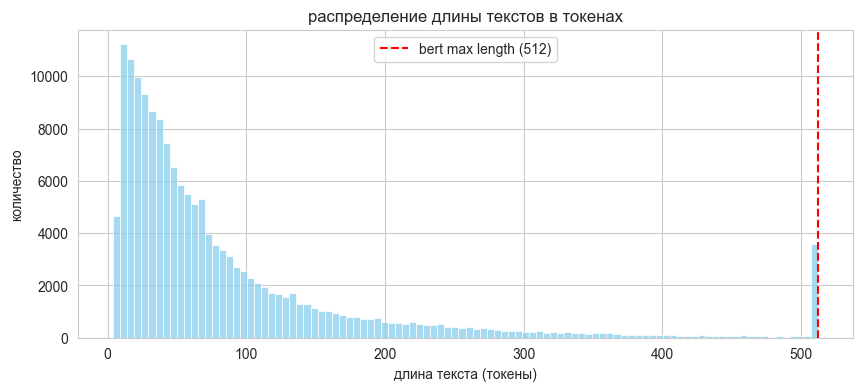

In [43]:
# гистограмма длины в токенах
plt.figure(figsize=(10, 4))
sns.histplot(df['token_length'], bins=100, color='skyblue')
plt.title('распределение длины текстов в токенах')
plt.xlabel('длина текста (токены)')
plt.ylabel('количество')
plt.axvline(x=512, color='red', linestyle='--', label='bert max length (512)')
plt.legend()
plt.show()